In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/k league/k1리그최종 (3).csv',encoding='cp949' )


df['대회'] = df['대회'].str.replace('김천', '상주')
df['Team'] = df['Team'].str.replace('김천', '상주')
df['Home_Team'] = df['Home_Team'].str.replace('김천', '상주')
df['상대팀'] = df['상대팀'].str.replace('김천', '상주')
df['Home_Team'] = df['Home_Team'].str.replace('김천', '상주')
df['Away_Team'] = df['Away_Team'].str.replace('김천', '상주')
df.head()
# df = df.loc[df['year']==2022]

,Rnd,대회,H/A,득점,슈팅,유효 슈팅,PA내 슈팅,드리블 시도,드리블 성공,드리블 성공%,...,Team,상대팀,실점,결과,Home_Team,Away_Team,Home_win,Draw,Away_win,year
0,1,강원vs인천,HOME,2,10,6,8,16,6,37.5,...,강원,인천,1.0,승,강원,인천,NaN,NaN,NaN,2018
1,2,서울vs강원,AWAY,2,9,6,8,8,1,12.5,...,강원,서울,1.0,승,서울,강원,NaN,NaN,NaN,2018
2,3,강원vs상주,HOME,2,14,3,0,0,0,0.0,...,강원,상주,1.0,승,강원,상주,NaN,NaN,NaN,2018
3,4,강원vs경남,HOME,1,19,13,8,7,5,71.4,...,강원,경남,3.0,패,강원,경남,2.25,3.25,3.05,2018
4,5,울산vs강원,AWAY,1,16,8,12,12,5,41.7,...,강원,울산,3.0,패,울산,강원,2.40,3.15,2.90,2018


In [ ]:
df.Team.unique()

array(['강원', '경남', '대구', '상주', '서울', '수원', '울산', '인천', '전남', '전북', '제주',
       '포항', '성남', '광주', '부산', '수원FC', '대전'], dtype=object)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 컬럼들에 대해 정규화
columns_to_normalize = [
    'Player_Stats_득점',
    'Player_Stats_경합 공중 성공',
    'Player_Stats_유효 슈팅',
    'Player_Stats_키패스',
    'Player_Stats_인터셉트',
    'Player_Stats_클리어링',
    'Player_Stats_태클 성공',
    'Player_Stats_패스 성공%',
    'Player_Stats_드리블 성공',
    'Player_Stats_슈팅',
    'Player_Stats_크로스 성공'
]
def normalize_dict_column(column):
    all_values = []
    for row in column:
        values = eval(row).values() if isinstance(row, str) else row.values()
        all_values.extend(values)

    min_value = min(all_values)
    max_value = max(all_values)

    def normalize_dict(d):
        return {k: (v - min_value) / (max_value - min_value) if max_value != min_value else 0.5 for k, v in d.items()}

    return column.apply(lambda x: normalize_dict(eval(x)) if isinstance(x, str) else normalize_dict(x))

# 각 컬럼에 대해 정규화를 수행
for column in columns_to_normalize:
    df[column] = normalize_dict_column(df[column])
# df는 이제 정규화된 값을 포함하고 있음
print(df.head())


   Rnd      대회   H/A  득점  슈팅  유효 슈팅  PA내 슈팅  드리블 시도  드리블 성공  드리블 성공%  ...  \
0    1  강원vs인천  HOME   2  10      6       8      16       6     37.5  ...   
1    2  서울vs강원  AWAY   2   9      6       8       8       1     12.5  ...   
2    3  강원vs상주  HOME   2  14      3       0       0       0      0.0  ...   
3    4  강원vs경남  HOME   1  19     13       8       7       5     71.4  ...   
4    5  울산vs강원  AWAY   1  16      8      12      12       5     41.7  ...   

   Team  상대팀   실점  결과  Home_Team  Away_Team  Home_win  Draw  Away_win  year  
0    강원   인천  1.0   승         강원         인천       NaN   NaN       NaN  2018  
1    강원   서울  1.0   승         서울         강원       NaN   NaN       NaN  2018  
2    강원   상주  1.0   승         강원         상주       NaN   NaN       NaN  2018  
3    강원   경남  3.0   패         강원         경남      2.25  3.25      3.05  2018  
4    강원   울산  3.0   패         울산         강원      2.40  3.15      2.90  2018  

[5 rows x 62 columns]


In [ ]:
import pandas as pd
import numpy as np

# Initialize the Elo ratings for all players
initial_elo = 1500
players = set()
teams = df['Team'].unique()
team_ratings = {team: initial_elo for team in teams}

def safe_eval(val):
    if isinstance(val, dict):
        return val
    return eval(val)
for index, row in df.iterrows():
    for player_stats in row.filter(like='Player_Stats_').tolist():
        player_dict = safe_eval(player_stats) if isinstance(player_stats, str) else {}
        players.update(player_dict.keys())

elo_attack = {player: initial_elo for player in players}
elo_defense = {player: initial_elo for player in players}
elo_basic = {player: initial_elo for player in players}
q_values = {player: 1.0 for player in players}
k_values = {player: 32 for player in players}
player_clubs = {player: None for player in players}
previous_clubs = {player: None for player in players}
# Initialize player impact dictionary
player_impact = {player: 0 for player in players}
C_A_with = {player: 0 for player in players}
C_A_without = {player: 0 for player in players}
player_minutes_with = {player: 0 for player in players}
player_minutes_without = {player: 0 for player in players}

w = 1
k_A = 20

attack_weights = {
    '득점': 30,        # 가장 중요한 지표
    '경합 공중 성공': 3,
    '유효 슈팅': 23,
    '키패스': 13
}

defense_weights = {
    '인터셉트': 12,   # 가장 중요한 지표
    '클리어링': 12,
    '태클 성공': 12
}

basic_weights = {
    '패스 성공%': 4,
    '드리블 성공': 4,
    '슈팅': 4,
    '크로스 성공': 4
}

position_attack_weights = {
    'FW': 0.179,
    'MF': 0.285,
    'DF': 0.536,
    'GK': 0.25
}
position_defense_weights = {
    'FW': 0.467,
    'MF': 0.3,
    'DF': 0.233,
    'GK': 0.25
}
position_basic_weights = {
    'FW': 0.386,
    'MF': 0.311,
    'DF': 0.303,
    'GK': 0.25
}
# Function to calculate expected score


def expected_score(player_rating, opponent_avg_rating):
    return 1 / (1 + 10 ** ((opponent_avg_rating - player_rating) / 400))

# Function to calculate C_A_i with position weights and stats
def calculate_C_A_i(S_A_i, E_A_i, D_A_i, M_A_i, player_stats, position, metric_weights, position_weights):
    stats_weight = sum([player_stats.get(stat, 0) * weight for stat, weight in metric_weights.items()])
    if position in position_weights:
        C_A_i = stats_weight * position_weights[position] + w * (S_A_i - E_A_i) * (abs(D_A_i)**(1/3) if D_A_i != 0 else 1)
    else:  # 포지션이 "대기"인 경우
        C_A_i = 0
    return C_A_i

# Function to update Elo rating
def update_elo(R_A_i, C_A_i, q_A_i, k_A_i, C_A, M_A_i):
    return R_A_i + k_A_i * (q_A_i * C_A_i + (1 - q_A_i) * C_A * (M_A_i / M_max))

# Function to update q value
def update_q_value(player, changed_club, was_on_pitch):
    if changed_club:
        q_values[player] = 1
    elif not was_on_pitch:
        q_values[player] = max(q_values[player] - 0.025, 0.5)
    else:
        q_values[player] = min(q_values[player] + 0.025, 1.0)

# Function to update k value
def update_k_value(player, changed_club, was_on_pitch):
    if changed_club:
        k_values[player] = 40
    elif not was_on_pitch:
        k_values[player] = min(k_values[player] + 0.5, 40)
    else:
        k_values[player] = max(k_values[player] - 0.25, 10)

# Create a dictionary to store Elo rating history for all players
elo_history = {player: [] for player in players}

# Function to find opponent players
def find_opponent_players(round_num, opponent_team, year):
    opponent_players = {}
    for idx, match in df.iterrows():
        if match['Rnd'] == round_num and match['Team'] == opponent_team and match['year']==year:
            opponent_players.update(safe_eval(match['Player_Stats_출전시간(분)']))
            break
    return opponent_players
def calculate_I_A_i(player, player_minutes_with, player_minutes_without, C_A_with, C_A_without):
    """
    Calculate the player impact I_A_i.

    :param player: Player ID or name
    :param player_minutes_with: Total minutes the player was on the pitch
    :param player_minutes_without: Total minutes the team played without the player
    :param C_A_with: Sum of team rating changes with the player
    :param C_A_without: Sum of team rating changes without the player
    :return: Player impact I_A_i
    """
    if player_minutes_with < 900 and player_minutes_without < 900:
        I_A_i = (C_A_with - C_A_without) * (0.1 + player_minutes_with / 900) * (0.1 + player_minutes_without / 900)
    elif player_minutes_with < 900:
        I_A_i = (C_A_with - C_A_without * (90 / player_minutes_without)) * (0.1 + player_minutes_with / 900)
    elif player_minutes_without < 900:
        I_A_i = (C_A_with / player_minutes_with - C_A_without) * (0.1 + player_minutes_without / 900)
    else:
        I_A_i = ((C_A_with / player_minutes_with) - (C_A_without / player_minutes_without)) * 90

    return I_A_i




# Process each match and store Elo rating updates
for index, row in df.iterrows():
    round_num = row['Rnd']
    team = row['Team']
    opponent_team = row['상대팀']
    team_score = row['득점']
    opponent_score = row['실점']
    result = row['결과']
    year = row['year']

    team_players = safe_eval(row['Player_Stats_출전시간(분)'])
    opponent_players = find_opponent_players(round_num, opponent_team,year)


    M_max = max(safe_eval(row['Player_Stats_출전시간(분)']).values())
    team_avg_attack = np.average(
        [elo_attack[player] for player in team_players.keys()],
        weights=[safe_eval(row['Player_Stats_출전시간(분)'])[player] for player in team_players.keys()]
    )
    team_avg_defense = np.average(
        [elo_defense[player] for player in team_players.keys()],
        weights=[safe_eval(row['Player_Stats_출전시간(분)'])[player] for player in team_players.keys()]
    )
    team_avg_basic = np.average(
        [elo_basic[player] for player in team_players.keys()],
        weights=[safe_eval(row['Player_Stats_출전시간(분)'])[player] for player in team_players.keys()]
    )

    opponent_avg_attack = np.average(
        [elo_attack[player] for player in opponent_players.keys()],
        weights=[opponent_players.get(player,0) for player in opponent_players.keys()]
    )
    opponent_avg_defense = np.average(
        [elo_defense[player] for player in opponent_players.keys()],
       weights=[opponent_players.get(player,0) for player in opponent_players.keys()]
    )
    opponent_avg_basic = np.average(
        [elo_basic[player] for player in opponent_players.keys()],
        weights=[opponent_players.get(player,0) for player in opponent_players.keys()]
    )

    team_avg_rating=(team_avg_attack + team_avg_defense + team_avg_basic) / 3
    team_ratings[team] = team_avg_rating
    opponent_avg_rating = (opponent_avg_attack + opponent_avg_defense + opponent_avg_basic) / 3
    team_ratings[opponent_team] = opponent_avg_rating

    team_actual = 1 if result == '승' else 0.5 if result == '무' else 0
    team_expected = expected_score(team_avg_attack, opponent_avg_rating)
    C_A = k_A * (team_actual - team_expected)
    for player, minutes in team_players.items():
        if minutes > 0:
            player_minutes_with[player] += minutes
            C_A_with[player] += C_A * (minutes /  M_max)
        if minutes==0:
            player_minutes_without[player] += M_max
            C_A_without[player] += C_A




    Impact = {'Impact':{}}
    match_elo_ratings = {'attack': {}, 'defense': {}, 'basic': {}}
    for player, minutes_played in safe_eval(row['Player_Stats_출전시간(분)']).items():
        if player in elo_attack:
            player_position = safe_eval(row['Player_Stats_포지션'])[player]
            player_stats = {
                '득점': safe_eval(row['Player_Stats_득점']).get(player, 0),
                '경합 공중 성공': safe_eval(row['Player_Stats_경합 공중 성공']).get(player, 0),
                '유효 슈팅': safe_eval(row['Player_Stats_유효 슈팅']).get(player, 0),
                '키패스': safe_eval(row['Player_Stats_키패스']).get(player, 0),
                '인터셉트': safe_eval(row['Player_Stats_인터셉트']).get(player, 0),
                '클리어링': safe_eval(row['Player_Stats_클리어링']).get(player, 0),
                '태클 성공': safe_eval(row['Player_Stats_태클 성공']).get(player, 0),
                '패스 성공%': safe_eval(row['Player_Stats_패스 성공%']).get(player, 0),
                '드리블 성공': safe_eval(row['Player_Stats_드리블 성공']).get(player, 0),
                '슈팅': safe_eval(row['Player_Stats_슈팅']).get(player, 0),
                '크로스 성공': safe_eval(row['Player_Stats_크로스 성공']).get(player, 0)
            }

            attack_stats = {
                '득점': player_stats['득점'],
                '경합 공중 성공': player_stats['경합 공중 성공'],
                '유효 슈팅': player_stats['유효 슈팅'],
                '키패스': player_stats['키패스']
            }
            defense_stats = {
                '인터셉트': player_stats['인터셉트'],
                '클리어링': player_stats['클리어링'],
                '태클 성공': player_stats['태클 성공']
            }
            basic_stats = {
                '패스 성공%': player_stats['패스 성공%'],
                '드리블 성공': player_stats['드리블 성공'],
                '슈팅': player_stats['슈팅'],
                '크로스 성공': player_stats['크로스 성공']
            }

            S_A_i = team_actual * (minutes_played / M_max)
            E_A_i_attack = expected_score(elo_attack[player], opponent_avg_rating)
            E_A_i_defense = expected_score(elo_defense[player], opponent_avg_rating)
            E_A_i_basic = expected_score(elo_basic[player], opponent_avg_rating)


            D_A_i = (team_score - opponent_score) * (minutes_played / M_max)
            C_A_i_attack = calculate_C_A_i(S_A_i, E_A_i_attack, D_A_i, minutes_played, attack_stats, player_position, attack_weights, position_attack_weights)
            C_A_i_defense = calculate_C_A_i(S_A_i, E_A_i_defense, D_A_i, minutes_played, defense_stats, player_position, defense_weights, position_defense_weights)
            C_A_i_basic = calculate_C_A_i(S_A_i, E_A_i_basic, D_A_i, minutes_played, basic_stats, player_position, basic_weights, position_basic_weights)
            elo_attack[player] = update_elo(elo_attack[player], C_A_i_attack, q_values[player], k_values[player], C_A, minutes_played)
            elo_defense[player] = update_elo(elo_defense[player], C_A_i_defense, q_values[player], k_values[player], C_A, minutes_played)
            elo_basic[player] = update_elo(elo_basic[player], C_A_i_basic, q_values[player], k_values[player], C_A, minutes_played)

            player_impact[player] = calculate_I_A_i(player, player_minutes_with[player], player_minutes_without[player], C_A_with[player], C_A_without[player])
            Impact['Impact'][player] = player_impact[player]


            match_elo_ratings['attack'][player] = elo_attack[player]
            match_elo_ratings['defense'][player] = elo_defense[player]
            match_elo_ratings['basic'][player] = elo_basic[player]
            elo_history[player].append((elo_attack[player], elo_defense[player], elo_basic[player]))
            changed_club = player_clubs[player] is not None and player_clubs[player] != team
            previous_clubs[player] = player_clubs[player]
            player_clubs[player] = team

            # Update q and k values based on conditions
            was_on_pitch = minutes_played > 0
            update_q_value(player, changed_club, was_on_pitch)
            update_k_value(player, changed_club, was_on_pitch)
    df.at[index, 'Impact_score'] =str(Impact['Impact'])
    df.at[index, 'Elo_Ratings_Attack'] = str(match_elo_ratings['attack'])
    df.at[index, 'Elo_Ratings_Defense'] = str(match_elo_ratings['defense'])
    df.at[index, 'Elo_Ratings_Basic'] = str(match_elo_ratings['basic'])
# Calculate team ratings based on individual metrics
for index, row in df.iterrows():
    if pd.notnull(row['Elo_Ratings_Attack']):
        match_ratings_attack = safe_eval(row['Elo_Ratings_Attack'])
        match_ratings_defense = safe_eval(row['Elo_Ratings_Defense'])
        match_ratings_basic = safe_eval(row['Elo_Ratings_Basic'])
        impact_scores = safe_eval(row['Impact_score'])

        team = row['Team']
        year = row['year']
        opponent_team = row['상대팀']

        # Find opponent players
        opponent_players = find_opponent_players(row['Rnd'], opponent_team,year)

        team_attack_ratings = [match_ratings_attack[player] for player in match_ratings_attack]
        team_defense_ratings = [match_ratings_defense[player] for player in match_ratings_defense]
        team_basic_ratings = [match_ratings_basic[player] for player in match_ratings_basic]
        team_impact_scores = [impact_scores[player] for player in impact_scores]

        df.at[index, 'Team_Attack_Rating'] = np.mean(team_attack_ratings) if team_attack_ratings else 0
        df.at[index, 'Team_Defense_Rating'] = np.mean(team_defense_ratings) if team_defense_ratings else 0
        df.at[index, 'Team_Basic_Rating'] = np.mean(team_basic_ratings) if team_basic_ratings else 0
        df.at[index, 'Team_Rating'] = (df.at[index, 'Team_Attack_Rating'] + df.at[index, 'Team_Defense_Rating'] + df.at[index, 'Team_Basic_Rating']) / 3
        df.at[index, 'Team_Impact_Score'] = np.mean(team_impact_scores) if team_impact_scores else 0

        # Calculate opponent team ratings based on the round and opponent team
        opponent_round_data = df[(df['Rnd'] == row['Rnd']) & (df['Team'] == opponent_team)& (df['year'] == year)]

        if not opponent_round_data.empty:
            opponent_ratings_attack = safe_eval(opponent_round_data['Elo_Ratings_Attack'].values[0])
            opponent_ratings_defense = safe_eval(opponent_round_data['Elo_Ratings_Defense'].values[0])
            opponent_ratings_basic = safe_eval(opponent_round_data['Elo_Ratings_Basic'].values[0])

            opponent_attack_ratings = [opponent_ratings_attack[player] for player in opponent_ratings_attack if player in opponent_players]
            opponent_defense_ratings = [opponent_ratings_defense[player] for player in opponent_ratings_defense if player in opponent_players]
            opponent_basic_ratings = [opponent_ratings_basic[player] for player in opponent_ratings_basic if player in opponent_players]

            df.at[index, 'Opponent_Team_Attack_Rating'] = np.mean(opponent_attack_ratings) if opponent_attack_ratings else 0
            df.at[index, 'Opponent_Team_Defense_Rating'] = np.mean(opponent_defense_ratings) if opponent_defense_ratings else 0
            df.at[index, 'Opponent_Team_Basic_Rating'] = np.mean(opponent_basic_ratings) if opponent_basic_ratings else 0
            df.at[index, 'Opponent_Team_Rating'] = (df.at[index, 'Opponent_Team_Attack_Rating'] + df.at[index, 'Opponent_Team_Defense_Rating'] + df.at[index, 'Opponent_Team_Basic_Rating']) / 3
# Convert the Elo history dictionary to a DataFrame for display
elo_history_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in elo_history.items()]))


# Display player impact
df.head()

# Define the number of top players to display
N = 30



# Extract the Elo ratings for attack, defense, and basic from the last round
attack_ratings = {}
defense_ratings = {}
basic_ratings = {}
clubs = {}
positions = {}
Impact = {}

for index, row in df.iterrows():
    match_ratings_attack = eval(row['Elo_Ratings_Attack'])
    match_ratings_defense = eval(row['Elo_Ratings_Defense'])
    match_ratings_basic = eval(row['Elo_Ratings_Basic'])
    Impact_score = eval(row['Impact_score'])
    team = row['Team']
    player_positions = eval(row['Player_Stats_포지션'])  # 포지션 데이터 추가

    for player, rating in match_ratings_attack.items():
        attack_ratings[player] = rating
        clubs[player] = team
        if player_positions[player] != '대기':
            positions[player] = player_positions[player]  # "대기"가 아닌 포지션 설정

    for player, rating in match_ratings_defense.items():
        defense_ratings[player] = rating
        clubs[player] = team
        if player not in positions and player_positions[player] != '대기':  # 포지션이 아직 설정되지 않은 경우
            positions[player] = player_positions[player]

    for player, rating in match_ratings_basic.items():
        basic_ratings[player] = rating
        clubs[player] = team
        if player not in positions and player_positions[player] != '대기':  # 포지션이 아직 설정되지 않은 경우
            positions[player] = player_positions[player]

    for player, score in Impact_score.items():
        Impact[player] = score
        clubs[player] = team
        if player not in positions and player_positions[player] != '대기':  # 포지션이 아직 설정되지 않은 경우
            positions[player] = player_positions[player]

# "대기"가 아닌 포지션으로 업데이트
for player in positions.keys():
    if positions[player] == '대기':
        for index, row in df.iterrows():
            player_positions = eval(row['Player_Stats_포지션'])
            if player in player_positions and player_positions[player] != '대기':
                positions[player] = player_positions[player]
                break

# Convert dictionaries to dataframes
attack_df = pd.DataFrame(list(attack_ratings.items()), columns=['Player', 'Attack_Rating'])
attack_df['Club'] = attack_df['Player'].map(clubs)
attack_df['Position'] = attack_df['Player'].map(positions)  # 포지션 추가

defense_df = pd.DataFrame(list(defense_ratings.items()), columns=['Player', 'Defense_Rating'])
defense_df['Club'] = defense_df['Player'].map(clubs)
defense_df['Position'] = defense_df['Player'].map(positions)  # 포지션 추가

basic_df = pd.DataFrame(list(basic_ratings.items()), columns=['Player', 'Basic_Rating'])
basic_df['Club'] = basic_df['Player'].map(clubs)
basic_df['Position'] = basic_df['Player'].map(positions)  # 포지션 추가

Impact_df = pd.DataFrame(list(Impact.items()), columns=['Player', 'Impact_score'])
Impact_df['Club'] = Impact_df['Player'].map(clubs)
Impact_df['Position'] = Impact_df['Player'].map(positions)  # 포지션 추가

# Sort dataframes by ratings and select top N players
top_attack_players = attack_df.sort_values(by='Attack_Rating', ascending=False).head(N)
top_defense_players = defense_df.sort_values(by='Defense_Rating', ascending=False).head(N)
top_basic_players = basic_df.sort_values(by='Basic_Rating', ascending=False).head(N)
top_Impact_players = Impact_df.sort_values(by='Impact_score', ascending=False).head(N)

# Display the top N players for each rating category
print("Top Attack Players:")
print(top_attack_players)

print("\nTop Defense Players:")
print(top_defense_players)

print("\nTop Basic Players:")
print(top_basic_players)

print("\nTop Impact Players:")
print(top_Impact_players)



attack_correct = top_attack_players['Position'].isin(['FW', 'MF']).sum()
defense_correct = top_defense_players['Position'].isin(['DF', 'GK','MF']).sum()

total_correct = attack_correct + defense_correct
print(total_correct/(2*N))


<ipython-input-13-88ace30d8e57>:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, 'Team_Impact_Score'] = np.mean(team_impact_scores) if team_impact_scores else 0


Top Attack Players:
    Player  Attack_Rating  Club Position
121   윤빛가람    6657.654436  수원FC       MF
115    주민규    6398.216410    울산       FW
91     세징야    5867.952238    대구       FW
557  팔로세비치    5610.711147    서울       MF
327    로페즈    5391.511610  수원FC       FW
298    완델손    5363.542841    포항       DF
555   일류첸코    5328.475942    서울       FW
385    강상우    5306.630316    서울       DF
402    송민규    5257.824239    전북       MF
266    문선민    5237.787901    전북       MF
107    김태환    5116.869497    제주       DF
228    주니오    5050.555680    울산       FW
229    이영재    4999.088483    전북       MF
151    신진호    4790.993297    인천       MF
635    나상호    4684.867451    서울       FW
265    무고사    4666.330971    인천       FW
661     라스    4495.776990  수원FC       FW
660    조규성    4448.431630    전북       FW
84     김대원    4429.189584    상주       FW
369    정태욱    4287.638917    전북       DF
769    그랜트    4242.533101    포항       DF
740     바코    4189.484984    울산       MF
323    김진수    4140.125516    전북      

In [ ]:
grouped = df.groupby(['Home_Team', 'Away_Team'])

# 그룹별 평균을 사용하여 결측치 대체
df['Home_win'] = grouped['Home_win'].transform(lambda x: x.fillna(x.mean()))
df['Draw'] = grouped['Draw'].transform(lambda x: x.fillna(x.mean()))
df['Away_win'] = grouped['Away_win'].transform(lambda x: x.fillna(x.mean()))

# 그룹 내 평균으로 대체되지 않은 결측치에 대해 전체 평균으로 대체
df['Home_win'] = df['Home_win'].fillna(df['Home_win'].mean())
df['Draw'] = df['Draw'].fillna(df['Draw'].mean())
df['Away_win'] = df['Away_win'].fillna(df['Away_win'].mean())

print("결측치 대체 후 데이터프레임:")
print(df)

# 결측치가 있는지 확인
print("\n결측치가 남아 있는 행들:")
print(df[df['Home_win'].isnull() | df['Draw'].isnull() | df['Away_win'].isnull()])

결측치 대체 후 데이터프레임:
      Rnd      대회   H/A  득점  슈팅  유효 슈팅  PA내 슈팅  드리블 시도  드리블 성공  드리블 성공%  ...  \
0       1  강원vs인천  HOME   2  10      6       8      16       6     37.5  ...   
1       2  서울vs강원  AWAY   2   9      6       8       8       1     12.5  ...   
2       3  강원vs상주  HOME   2  14      3       0       0       0      0.0  ...   
3       4  강원vs경남  HOME   1  19     13       8       7       5     71.4  ...   
4       5  울산vs강원  AWAY   1  16      8      12      12       5     41.7  ...   
...   ...     ...   ...  ..  ..    ...     ...     ...     ...      ...  ...   
2729    7  서울vs포항  AWAY   4   6      5       6       5       3     60.0  ...   
2730    8  포항vs상주  HOME   0  12      2       6       5       1     20.0  ...   
2731    9  포항vs인천  HOME   0  10      2       4       3       0      0.0  ...   
2732   10  강원vs포항  AWAY   4  11      4       8       3       1     33.3  ...   
2733   11  포항vs전북  HOME   1  24      5      15      13       5     38.5  ...   

      Team_Ratingshift

In [ ]:
df['Team_win'] = df.apply(lambda row: row['Home_win'] if row['Team']==row['Home_Team'] else row['Away_win'],axis = 1)
df['Opponent_win'] = df.apply(lambda row: row['Away_win'] if row['Team']==row['Home_Team'] else row['Away_win'],axis = 1)

In [ ]:
df.columns

In [ ]:
# df.columns
# # 'Rnd', '대회''Player_Stats_포지션',
#        'Player_Stats_출전시간(분)', 'Player_Stats_득점', 'Player_Stats_인터셉트',
#        'Player_Stats_클리어링', 'Player_Stats_경합 공중 성공', 'Player_Stats_태클 성공',
#        'Player_Stats_유효 슈팅', 'Player_Stats_키패스', 'Player_Stats_패스 성공%',
#        'Player_Stats_드리블 성공', 'Player_Stats_슈팅', 'Player_Stats_크로스 성공'
# 'Home_Team', 'Away_Team'
#'year', 'Impact_score', 'Elo_Ratings_Attack',
      #  'Elo_Ratings_Defense', 'Elo_Ratings_Basic'

Index(['Rnd', '대회', 'H/A', '득점', '슈팅', '유효 슈팅', 'PA내 슈팅', '드리블 시도', '드리블 성공',
       '드리블 성공%', '패스 시도', '패스 성공', '패스 성공%', '키패스', '공격진영 패스 시도',
       '공격진영 패스 성공', '공격진영 패스 성공%', '수비진영 패스 시도', '수비진영 성공', '수비진영 성공%',
       '롱패스 시도', '롱패스 성공', '롱패스 성공%', '크로스 시도', '크로스 성공', '크로스 성공%',
       '경합 지상 성공', '경합 지상 성공%', '경합 공중 시도', '경합 공중 성공', '경합 공중 성공%', '태클 시도',
       '태클 성공', '태클 성공%', '클리어링', '인터셉트', '파울', '경고', '퇴장', 'Player_Stats_포지션',
       'Player_Stats_출전시간(분)', 'Player_Stats_득점', 'Player_Stats_인터셉트',
       'Player_Stats_클리어링', 'Player_Stats_경합 공중 성공', 'Player_Stats_태클 성공',
       'Player_Stats_유효 슈팅', 'Player_Stats_키패스', 'Player_Stats_패스 성공%',
       'Player_Stats_드리블 성공', 'Player_Stats_슈팅', 'Player_Stats_크로스 성공', 'Team',
       '상대팀', '실점', '결과', 'Home_Team', 'Away_Team', 'Home_win', 'Draw',
       'Away_win', 'year', 'Impact_score', 'Elo_Ratings_Attack',
       'Elo_Ratings_Defense', 'Elo_Ratings_Basic', 'Team_Attack_Rating',
       'Team_Defense_Rating', 'Team_Basic_Ratin

In [ ]:

# 이동평균을 계산할 컬럼 목록
columns_to_avg = ['득점', '슈팅', '유효 슈팅', 'PA내 슈팅', '드리블 시도', '드리블 성공',
                 '드리블 성공%', '패스 시도', '패스 성공', '패스 성공%', '키패스', '공격진영 패스 시도',
                 '공격진영 패스 성공', '공격진영 패스 성공%', '수비진영 패스 시도', '수비진영 성공', '수비진영 성공%',
                 '롱패스 시도', '롱패스 성공', '롱패스 성공%', '크로스 시도', '크로스 성공', '크로스 성공%',
                 '경합 지상 성공', '경합 지상 성공%', '경합 공중 시도', '경합 공중 성공', '경합 공중 성공%', '태클 시도',
                 '태클 성공', '태클 성공%', '클리어링', '인터셉트', '파울', '경고', '퇴장', '실점']

ratings_columns = ['Team_Attack_Rating', 'Team_Defense_Rating', 'Team_Basic_Rating', 'Team_Rating',
                   'Opponent_Team_Attack_Rating', 'Opponent_Team_Defense_Rating', 'Opponent_Team_Basic_Rating',
                   'Opponent_Team_Rating']
# 이동평균을 계산할 윈도우 크기
window_size = 5

# 팀별로 이동평균 계산 (이전 경기들의 평균 사용)
for col in columns_to_avg:
    df[f'Team_{col}_avg'] = df.groupby('Team')[col].transform(lambda x: x.shift().rolling(window=window_size, min_periods=1).mean())
    df[f'Team_vs_Opponent_{col}_avg'] = df.groupby(['Team', '상대팀'])[col].transform(lambda x: x.shift().rolling(window=window_size, min_periods=1).mean())
for col in ratings_columns:
    df[col+'shifted1'] = df.groupby('Team')[col].shift(1)
    df[col+'shifted2'] = df.groupby(['Team', '상대팀'])[col].shift(1)

df.isnull().sum()

Rnd                                     0
대회                                      0
H/A                                     0
득점                                      0
슈팅                                      0
                                     ... 
Opponent_Team_Basic_Ratingshifted1     17
Opponent_Team_Basic_Ratingshifted2    246
Opponent_Team_Ratingshifted1           17
Opponent_Team_Ratingshifted2          246
Team_Impact_Score                       0
Length: 167, dtype: int64

In [ ]:
df['Team'].unique()

array(['강원', '경남', '대구', '상주', '서울', '수원', '울산', '인천', '전남', '전북', '제주',
       '포항', '성남', '광주', '부산', '수원FC', '대전'], dtype=object)

In [ ]:
df

,Rnd,대회,H/A,득점,슈팅,유효 슈팅,PA내 슈팅,드리블 시도,드리블 성공,드리블 성공%,...,Team_Ratingshifted2,Opponent_Team_Attack_Ratingshifted1,Opponent_Team_Attack_Ratingshifted2,Opponent_Team_Defense_Ratingshifted1,Opponent_Team_Defense_Ratingshifted2,Opponent_Team_Basic_Ratingshifted1,Opponent_Team_Basic_Ratingshifted2,Opponent_Team_Ratingshifted1,Opponent_Team_Ratingshifted2,Team_Impact_Score
0,1,강원vs인천,HOME,2,10,6,8,16,6,37.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.074758
1,2,서울vs강원,AWAY,2,9,6,8,8,1,12.5,...,NaN,1540.023462,NaN,1518.047611,NaN,1553.158438,NaN,1537.076504,NaN,0.186749
2,3,강원vs상주,HOME,2,14,3,0,0,0,0.0,...,NaN,1512.282607,NaN,1510.283172,NaN,1524.516690,NaN,1515.694156,NaN,0.348423
3,4,강원vs경남,HOME,1,19,13,8,7,5,71.4,...,NaN,1556.491535,NaN,1530.238143,NaN,1554.302493,NaN,1547.010724,NaN,0.341183
4,5,울산vs강원,AWAY,1,16,8,12,12,5,41.7,...,NaN,1620.599392,NaN,1602.510612,NaN,1627.643733,NaN,1616.917913,NaN,0.070513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,7,서울vs포항,AWAY,4,6,5,6,5,3,60.0,...,3144.006731,2187.613807,3094.230248,2431.688970,3042.799832,2538.136168,3420.137552,2385.812982,3185.722544,-5.832054
2730,8,포항vs상주,HOME,0,12,2,6,5,1,20.0,...,3077.028702,2831.414298,2345.351873,2554.921953,2489.918387,3073.467768,2740.936938,2819.934673,2525.402399,-5.605991
2731,9,포항vs인천,HOME,0,10,2,4,3,0,0.0,...,3153.715347,2618.158024,2911.045534,2940.747568,3436.752605,3117.421565,3479.169844,2892.109052,3275.655994,-5.774304
2732,10,강원vs포항,AWAY,4,11,4,8,3,1,33.3,...,2991.150035,2716.976812,2330.145516,3031.281478,2569.168470,3137.913953,2757.649569,2962.057414,2552.321185,-6.195336


In [ ]:
drop_cols=['Rnd',
 '대회',
 '득점',
 '슈팅',
 '유효 슈팅',
 'PA내 슈팅',
 '드리블 시도',
 '드리블 성공',
 '드리블 성공%',
 '패스 시도',
 '패스 성공',
 '패스 성공%',
 '키패스',
 '공격진영 패스 시도',
 '공격진영 패스 성공',
 '공격진영 패스 성공%',
 '수비진영 패스 시도',
 '수비진영 성공',
 '수비진영 성공%',
 '롱패스 시도',
 '롱패스 성공',
 '롱패스 성공%',
 '크로스 시도',
 '크로스 성공',
 '크로스 성공%',
 '경합 지상 성공',
 '경합 지상 성공%',
 '경합 공중 시도',
 '경합 공중 성공',
 '경합 공중 성공%',
 '태클 시도',
 '태클 성공',
 '태클 성공%',
 '클리어링',
 '인터셉트',
 '파울',
 '경고',
 '퇴장',
 'Player_Stats_포지션',
 'Player_Stats_출전시간(분)',
 'Player_Stats_득점',
 'Player_Stats_인터셉트',
 'Player_Stats_클리어링',
 'Player_Stats_경합 공중 성공',
 'Player_Stats_태클 성공',
 'Player_Stats_유효 슈팅',
 'Player_Stats_키패스',
 'Player_Stats_패스 성공%',
 'Player_Stats_드리블 성공',
 'Player_Stats_슈팅',
 'Player_Stats_크로스 성공',
 '실점',
 'Home_Team',
 'Away_Team',
 'Home_win',
 'Away_win',
 'Impact_score',
 'Elo_Ratings_Attack',
 'Elo_Ratings_Defense',
 'Elo_Ratings_Basic',
 'Team_Attack_Rating',
 'Team_Defense_Rating',
 'Team_Basic_Rating',
 'Team_Rating',
 'Opponent_Team_Attack_Rating',
 'Opponent_Team_Defense_Rating',
 'Opponent_Team_Basic_Rating',
 'Opponent_Team_Rating'
 ]
df2 = df.drop(columns = drop_cols)
df2.columns.to_list()

['H/A',
 'Team',
 '상대팀',
 '결과',
 'Draw',
 'year',
 'Team_win',
 'Opponent_win',
 'Team_득점_avg',
 'Team_vs_Opponent_득점_avg',
 'Team_슈팅_avg',
 'Team_vs_Opponent_슈팅_avg',
 'Team_유효 슈팅_avg',
 'Team_vs_Opponent_유효 슈팅_avg',
 'Team_PA내 슈팅_avg',
 'Team_vs_Opponent_PA내 슈팅_avg',
 'Team_드리블 시도_avg',
 'Team_vs_Opponent_드리블 시도_avg',
 'Team_드리블 성공_avg',
 'Team_vs_Opponent_드리블 성공_avg',
 'Team_드리블 성공%_avg',
 'Team_vs_Opponent_드리블 성공%_avg',
 'Team_패스 시도_avg',
 'Team_vs_Opponent_패스 시도_avg',
 'Team_패스 성공_avg',
 'Team_vs_Opponent_패스 성공_avg',
 'Team_패스 성공%_avg',
 'Team_vs_Opponent_패스 성공%_avg',
 'Team_키패스_avg',
 'Team_vs_Opponent_키패스_avg',
 'Team_공격진영 패스 시도_avg',
 'Team_vs_Opponent_공격진영 패스 시도_avg',
 'Team_공격진영 패스 성공_avg',
 'Team_vs_Opponent_공격진영 패스 성공_avg',
 'Team_공격진영 패스 성공%_avg',
 'Team_vs_Opponent_공격진영 패스 성공%_avg',
 'Team_수비진영 패스 시도_avg',
 'Team_vs_Opponent_수비진영 패스 시도_avg',
 'Team_수비진영 성공_avg',
 'Team_vs_Opponent_수비진영 성공_avg',
 'Team_수비진영 성공%_avg',
 'Team_vs_Opponent_수비진영 성공%_avg',
 'Team_롱패스 시도_avg',
 '

In [ ]:
df2.columns

Index(['H/A', 'Team', '상대팀', '결과', 'Draw', 'year', 'Team_win', 'Opponent_win',
       'Team_득점_avg', 'Team_vs_Opponent_득점_avg', 'Team_슈팅_avg',
       'Team_vs_Opponent_슈팅_avg', 'Team_유효 슈팅_avg',
       'Team_vs_Opponent_유효 슈팅_avg', 'Team_PA내 슈팅_avg',
       'Team_vs_Opponent_PA내 슈팅_avg', 'Team_드리블 시도_avg',
       'Team_vs_Opponent_드리블 시도_avg', 'Team_드리블 성공_avg',
       'Team_vs_Opponent_드리블 성공_avg', 'Team_드리블 성공%_avg',
       'Team_vs_Opponent_드리블 성공%_avg', 'Team_패스 시도_avg',
       'Team_vs_Opponent_패스 시도_avg', 'Team_패스 성공_avg',
       'Team_vs_Opponent_패스 성공_avg', 'Team_패스 성공%_avg',
       'Team_vs_Opponent_패스 성공%_avg', 'Team_키패스_avg',
       'Team_vs_Opponent_키패스_avg', 'Team_공격진영 패스 시도_avg',
       'Team_vs_Opponent_공격진영 패스 시도_avg', 'Team_공격진영 패스 성공_avg',
       'Team_vs_Opponent_공격진영 패스 성공_avg', 'Team_공격진영 패스 성공%_avg',
       'Team_vs_Opponent_공격진영 패스 성공%_avg', 'Team_수비진영 패스 시도_avg',
       'Team_vs_Opponent_수비진영 패스 시도_avg', 'Team_수비진영 성공_avg',
       'Team_vs_Opponent_수비진영 성공_avg',

In [ ]:
df2.columns.to_list()

['H/A',
 'Team',
 '상대팀',
 '결과',
 'Draw',
 'year',
 'Team_win',
 'Opponent_win',
 'Team_득점_avg',
 'Team_vs_Opponent_득점_avg',
 'Team_슈팅_avg',
 'Team_vs_Opponent_슈팅_avg',
 'Team_유효 슈팅_avg',
 'Team_vs_Opponent_유효 슈팅_avg',
 'Team_PA내 슈팅_avg',
 'Team_vs_Opponent_PA내 슈팅_avg',
 'Team_드리블 시도_avg',
 'Team_vs_Opponent_드리블 시도_avg',
 'Team_드리블 성공_avg',
 'Team_vs_Opponent_드리블 성공_avg',
 'Team_드리블 성공%_avg',
 'Team_vs_Opponent_드리블 성공%_avg',
 'Team_패스 시도_avg',
 'Team_vs_Opponent_패스 시도_avg',
 'Team_패스 성공_avg',
 'Team_vs_Opponent_패스 성공_avg',
 'Team_패스 성공%_avg',
 'Team_vs_Opponent_패스 성공%_avg',
 'Team_키패스_avg',
 'Team_vs_Opponent_키패스_avg',
 'Team_공격진영 패스 시도_avg',
 'Team_vs_Opponent_공격진영 패스 시도_avg',
 'Team_공격진영 패스 성공_avg',
 'Team_vs_Opponent_공격진영 패스 성공_avg',
 'Team_공격진영 패스 성공%_avg',
 'Team_vs_Opponent_공격진영 패스 성공%_avg',
 'Team_수비진영 패스 시도_avg',
 'Team_vs_Opponent_수비진영 패스 시도_avg',
 'Team_수비진영 성공_avg',
 'Team_vs_Opponent_수비진영 성공_avg',
 'Team_수비진영 성공%_avg',
 'Team_vs_Opponent_수비진영 성공%_avg',
 'Team_롱패스 시도_avg',
 '

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# OneHotEncoder를 사용하여 'Team', '상대팀', '결과' 컬럼 변환
onehot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

# 'Team'과 '상대팀', '결과' 컬럼을 인코딩
teams_encoded = onehot_encoder.fit_transform(df2[['Team']])
opponents_encoded = onehot_encoder.fit_transform(df2[['상대팀']])

# 인코딩된 결과를 데이터프레임으로 변환하고, 컬럼명을 팀명으로 설정
team_columns = onehot_encoder.categories_[0]
opponent_columns = onehot_encoder.categories_[0]

teams_encoded_df = pd.DataFrame(teams_encoded, columns=[f'Team_{team}' for team in team_columns])
opponents_encoded_df = pd.DataFrame(opponents_encoded, columns=[f'상대팀_{opponent}' for opponent in opponent_columns])

# 원래 데이터프레임과 인코딩된 데이터프레임을 병합
df3 = pd.concat([df2, teams_encoded_df, opponents_encoded_df], axis=1)

# 원래 컬럼 삭제
df3.drop(['Team', '상대팀'], axis=1, inplace=True)
# '결과' 컬럼을 라벨인코딩하여 승(0), 무(1), 패(2)로 변환
result_mapping = {'승': 0, '무': 1, '패': 2}
HA_mapping = {'HOME': 0, 'AWAY': 1}

df3['결과'] = df3['결과'].map(result_mapping)


df3['H/A'] = df3['H/A'].map(HA_mapping)

# LabelEncoder를 사용하여 'year' 컬럼 변환
label_encoder = LabelEncoder()
df3['year'] = label_encoder.fit_transform(df3['year'])
# 결측치가 있는 행들을 제거
df3.dropna(inplace=True)
# 변환이 잘 되었는지 확인
print(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2488 entries, 11 to 2733
Columns: 131 entries, H/A to 상대팀_포항
dtypes: float64(128), int64(3)
memory usage: 2.5 MB
None


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,H/A,결과,Draw,year,Team_win,Opponent_win,Team_득점_avg,Team_vs_Opponent_득점_avg,Team_슈팅_avg,Team_vs_Opponent_슈팅_avg,...,상대팀_서울,상대팀_성남,상대팀_수원,상대팀_수원FC,상대팀_울산,상대팀_인천,상대팀_전남,상대팀_전북,상대팀_제주,상대팀_포항
11,1,2,3.30,0,2.70,2.70,2.0,2.0,11.8,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0,1,3.30,0,2.80,2.40,1.8,2.0,11.6,9.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1,0,3.45,0,2.85,2.85,1.2,1.0,12.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0,1,3.50,0,2.20,3.00,1.4,4.0,14.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15,1,1,3.40,0,2.35,2.35,1.6,2.0,12.6,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df3.year.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
team_columns

array(['강원', '경남', '광주', '대구', '대전', '부산', '상주', '서울', '성남', '수원', '수원FC',
       '울산', '인천', '전남', '전북', '제주', '포항'], dtype=object)

In [ ]:
df3.columns.to_list()

['H/A',
 '결과',
 'Draw',
 'year',
 'Team_win',
 'Opponent_win',
 'Team_득점_avg',
 'Team_vs_Opponent_득점_avg',
 'Team_슈팅_avg',
 'Team_vs_Opponent_슈팅_avg',
 'Team_유효 슈팅_avg',
 'Team_vs_Opponent_유효 슈팅_avg',
 'Team_PA내 슈팅_avg',
 'Team_vs_Opponent_PA내 슈팅_avg',
 'Team_드리블 시도_avg',
 'Team_vs_Opponent_드리블 시도_avg',
 'Team_드리블 성공_avg',
 'Team_vs_Opponent_드리블 성공_avg',
 'Team_드리블 성공%_avg',
 'Team_vs_Opponent_드리블 성공%_avg',
 'Team_패스 시도_avg',
 'Team_vs_Opponent_패스 시도_avg',
 'Team_패스 성공_avg',
 'Team_vs_Opponent_패스 성공_avg',
 'Team_패스 성공%_avg',
 'Team_vs_Opponent_패스 성공%_avg',
 'Team_키패스_avg',
 'Team_vs_Opponent_키패스_avg',
 'Team_공격진영 패스 시도_avg',
 'Team_vs_Opponent_공격진영 패스 시도_avg',
 'Team_공격진영 패스 성공_avg',
 'Team_vs_Opponent_공격진영 패스 성공_avg',
 'Team_공격진영 패스 성공%_avg',
 'Team_vs_Opponent_공격진영 패스 성공%_avg',
 'Team_수비진영 패스 시도_avg',
 'Team_vs_Opponent_수비진영 패스 시도_avg',
 'Team_수비진영 성공_avg',
 'Team_vs_Opponent_수비진영 성공_avg',
 'Team_수비진영 성공%_avg',
 'Team_vs_Opponent_수비진영 성공%_avg',
 'Team_롱패스 시도_avg',
 'Team_vs_Opponent_

In [ ]:
df3.shape

(2488, 129)

In [ ]:
df3.to_csv('kleague_final3.csv', index = False, encoding = 'cp949')

NameError: name 'df3' is not defined

In [ ]:
pip install catboost xgboost scikit-learn tensorflow


In [ ]:
import pandas as pd
df3 = pd.read_csv('/content/drive/MyDrive/k league/kleague_final3.csv',encoding = 'cp949')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# 데이터프레임 예시 (실제 데이터를 로드할 때 사용)
# df = pd.read_csv('path_to_your_data.csv')
# 연도별로 데이터 분할
train_df = df3[df3['year'] != 6]
test_df = df3[df3['year'] == 6]

# 입력(features)와 출력(label) 분리
X_train = train_df.drop('결과', axis=1)
y_train = train_df['결과']
X_test = test_df.drop('결과', axis=1)
y_test = test_df['결과']


# 로지스틱 회귀 모델 선택 및 훈련
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred)
log_reg_report = classification_report(y_test, y_pred)

print(f'Logistic Regression Accuracy: {log_reg_accuracy}')
print('Logistic Regression Classification Report:')
print(log_reg_report)

# CatBoostClassifier 모델 선택 및 훈련
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=False)
catboost_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = catboost_model.predict(X_test)
catboost_accuracy = accuracy_score(y_test, y_pred)
catboost_report = classification_report(y_test, y_pred)

print(f'CatBoost Accuracy: {catboost_accuracy}')
print('CatBoost Classification Report:')
print(catboost_report)

# 랜덤 포레스트 모델 선택 및 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_report = classification_report(y_test, y_pred)

print(f'Random Forest Accuracy: {rf_accuracy}')
print('Random Forest Classification Report:')
print(rf_report)

# XGBoost 모델 선택 및 훈련
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=6, verbosity=1)
xgb_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_report = classification_report(y_test, y_pred)

print(f'XGBoost Accuracy: {xgb_accuracy}')
print('XGBoost Classification Report:')
print(xgb_report)

# Decision Tree 모델 선택 및 훈련
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
dt_report = classification_report(y_test, y_pred)

print(f'Decision Tree Accuracy: {dt_accuracy}')
print('Decision Tree Classification Report:')
print(dt_report)

# ExtraTrees 모델 선택 및 훈련
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = et_model.predict(X_test)
et_accuracy = accuracy_score(y_test, y_pred)
et_report = classification_report(y_test, y_pred)

print(f'ExtraTrees Accuracy: {et_accuracy}')
print('ExtraTrees Classification Report:')
print(et_report)

# SVM 모델 선택 및 훈련
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# 모델 예측 및 평가
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_report = classification_report(y_test, y_pred)

print(f'SVM Accuracy: {svm_accuracy}')
print('SVM Classification Report:')
print(svm_report)

# DNN 모델 선택 및 훈련
# 레이블을 원핫인코딩
y_train_dnn = to_categorical(y_train)
y_test_dnn = to_categorical(y_test)

# DNN 모델 정의
dnn_model = Sequential()
dnn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(3, activation='softmax'))

# DNN 모델 컴파일
dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# DNN 모델 훈련
dnn_model.fit(X_train, y_train_dnn, epochs=50, batch_size=32, verbose=0)

# DNN 모델 예측 및 평가
_, dnn_accuracy = dnn_model.evaluate(X_test, y_test_dnn, verbose=0)
y_pred_dnn = dnn_model.predict(X_test)
y_pred_dnn_classes = y_pred_dnn.argmax(axis=-1)
dnn_report = classification_report(y_test, y_pred_dnn_classes)

print(f'DNN Accuracy: {dnn_accuracy}')
print('DNN Classification Report:')
print(dnn_report)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.40625
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.47      0.44        47
           1       0.33      0.24      0.28        34
           2       0.42      0.47      0.44        47

    accuracy                           0.41       128
   macro avg       0.39      0.39      0.39       128
weighted avg       0.40      0.41      0.40       128

CatBoost Accuracy: 0.40625
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.36      0.40        47
           1       0.30      0.29      0.30        34
           2       0.43      0.53      0.48        47

    accuracy                           0.41       128
   macro avg       0.40      0.40      0.39       128
weighted avg       0.41      0.41      0.40       128

Random Forest Accuracy: 0.390625
Random Forest Classification Report:
              precision    r

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Accuracy: 0.421875
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        47
           1       0.00      0.00      0.00        34
           2       0.41      0.66      0.50        47

    accuracy                           0.42       128
   macro avg       0.28      0.38      0.32       128
weighted avg       0.31      0.42      0.36       128

4/4 [==============================] - 0s 4ms/step
DNN Accuracy: 0.3671875
DNN Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28        47
           1       0.33      0.38      0.35        34
           2       0.36      0.53      0.43        47

    accuracy                           0.37       128
   macro avg       0.39      0.37      0.35       128
weighted avg       0.40      0.37      0.35       128



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# 데이터프레임 예시 (실제 데이터를 로드할 때 사용)
# df = pd.read_csv('path_to_your_data.csv')

train_df = df3[df3['year'] != 6]
test_df = df3[df3['year'] == 6]

# 입력(features)와 출력(label) 분리
X_train = train_df.drop('결과', axis=1)
y_train = train_df['결과']
X_test = test_df.drop('결과', axis=1)
y_test = test_df['결과']


# 개별 모델 정의
log_reg_model = LogisticRegression(max_iter=2000)
svc_model = SVC(probability=True, random_state=42)

models = {
    'Logistic Regression': log_reg_model,
    'SVC': svc_model
}


# Voting Classifier 정의 (하드 보팅)
voting_clf_hard = VotingClassifier(
    estimators=[
        ('lr', log_reg_model),
        ('svc', svc_model)
    ],
    voting='hard'
)

# Voting Classifier 정의 (소프트 보팅)
voting_clf_soft = VotingClassifier(
    estimators=[
        ('lr', log_reg_model),
        ('rf', rf_model),
        ('svc', svc_model)
    ],
    voting='soft'
)

# 하드 보팅 훈련 및 평가
voting_clf_hard.fit(X_train, y_train)
y_pred_hard = voting_clf_hard.predict(X_test)
hard_voting_accuracy = accuracy_score(y_test, y_pred_hard)
hard_voting_report = classification_report(y_test, y_pred_hard)

print(f'Hard Voting Accuracy: {hard_voting_accuracy}')
print('Hard Voting Classification Report:')
print(hard_voting_report)

# 소프트 보팅 훈련 및 평가
voting_clf_soft.fit(X_train, y_train)
y_pred_soft = voting_clf_soft.predict(X_test)
soft_voting_accuracy = accuracy_score(y_test, y_pred_soft)
soft_voting_report = classification_report(y_test, y_pred_soft)

print(f'Soft Voting Accuracy: {soft_voting_accuracy}')
print('Soft Voting Classification Report:')
print(soft_voting_report)

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

# 데이터프레임 예시 (실제 데이터를 로드할 때 사용)
# df = pd.read_csv('path_to_your_data.csv')


train_df = df3[df3['year'] != 6]
test_df = df3[df3['year'] == 6]

# 입력(features)와 출력(label) 분리
X_train = train_df.drop('결과', axis=1)
y_train = train_df['결과']
X_test = test_df.drop('결과', axis=1)
y_test = test_df['결과']


def optimize_logistic_regression(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    model = LogisticRegression(C=C, solver=solver, max_iter=2000)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

def optimize_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

# Optuna 스터디 생성 및 최적화 수행
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(optimize_logistic_regression, n_trials=50)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(optimize_random_forest, n_trials=50)

# 최적 하이퍼파라미터를 사용하여 모델 생성
best_lr = LogisticRegression(**study_lr.best_params, max_iter=2000)
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)

# 최적 모델을 사용하여 VotingClassifier 구성
voting_clf_hard = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
    ],
    voting='hard'
)

voting_clf_soft = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
    ],
    voting='soft'
)

# 하드 보팅 훈련 및 평가
voting_clf_hard.fit(X_train, y_train)
y_pred_hard = voting_clf_hard.predict(X_test)
hard_voting_accuracy = accuracy_score(y_test, y_pred_hard)
hard_voting_report = classification_report(y_test, y_pred_hard)

print(f'Hard Voting Accuracy: {hard_voting_accuracy}')
print('Hard Voting Classification Report:')
print(hard_voting_report)

# 소프트 보팅 훈련 및 평가
voting_clf_soft.fit(X_train, y_train)
y_pred_soft = voting_clf_soft.predict(X_test)
soft_voting_accuracy = accuracy_score(y_test, y_pred_soft)
soft_voting_report = classification_report(y_test, y_pred_soft)

print(f'Soft Voting Accuracy: {soft_voting_accuracy}')
print('Soft Voting Classification Report:')
print(soft_voting_report)


[I 2024-06-27 14:35:28,898] A new study created in memory with name: no-name-740b4a76-d635-4235-9b63-e5ee46d696c8
<ipython-input-9-dca6b0686eec>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergen

Hard Voting Accuracy: 0.390625
Hard Voting Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.72      0.52        47
           1       0.35      0.26      0.30        34
           2       0.37      0.15      0.21        47

    accuracy                           0.39       128
   macro avg       0.37      0.38      0.35       128
weighted avg       0.38      0.39      0.35       128

Soft Voting Accuracy: 0.3984375
Soft Voting Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        47
           1       0.29      0.21      0.24        34
           2       0.41      0.32      0.36        47

    accuracy                           0.40       128
   macro avg       0.38      0.38      0.37       128
weighted avg       0.39      0.40      0.38       128



In [ ]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# 데이터프레임 예시 (실제 데이터를 로드할 때 사용)
# df3 = pd.read_csv('path_to_your_data.csv')

# 모델의 입력(features)와 출력(label) 분리
X = df3.drop('결과', axis=1)
y = df3['결과']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터셋을 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def optimize_logistic_regression(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    model = LogisticRegression(C=C, solver=solver, max_iter=2000)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

def optimize_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

def optimize_extra_trees(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

# Optuna 스터디 생성 및 최적화 수행
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(optimize_logistic_regression, n_trials=50)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(optimize_random_forest, n_trials=50)

study_et = optuna.create_study(direction='maximize')
study_et.optimize(optimize_extra_trees, n_trials=50)

# 최적 하이퍼파라미터를 사용하여 모델 생성
best_lr = LogisticRegression(**study_lr.best_params, max_iter=2000)
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_et = ExtraTreesClassifier(**study_et.best_params, random_state=42)

# 최적 모델을 사용하여 VotingClassifier 구성
voting_clf_hard = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('et', best_et),
    ],
    voting='hard'
)

voting_clf_soft = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('et', best_et),
    ],
    voting='soft'
)

# 하드 보팅 훈련 및 평가
voting_clf_hard.fit(X_train, y_train)
y_pred_hard = voting_clf_hard.predict(X_test)
hard_voting_accuracy = accuracy_score(y_test, y_pred_hard)
hard_voting_report = classification_report(y_test, y_pred_hard)

print(f'Hard Voting Accuracy: {hard_voting_accuracy}')
print('Hard Voting Classification Report:')
print(hard_voting_report)

# 소프트 보팅 훈련 및 평가
voting_clf_soft.fit(X_train, y_train)
y_pred_soft = voting_clf_soft.predict(X_test)
soft_voting_accuracy = accuracy_score(y_test, y_pred_soft)
soft_voting_report = classification_report(y_test, y_pred_soft)

print(f'Soft Voting Accuracy: {soft_voting_accuracy}')
print('Soft Voting Classification Report:')
print(soft_voting_report)


[I 2024-06-26 06:26:03,660] A new study created in memory with name: no-name-b4d08367-32a8-4ba6-8394-85eb39c64c26
<ipython-input-36-ffc9285ba60b>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
[I 2024-06-26 06:26:04,548] Trial 0 finished with value: 0.4597989949748745 and parameters: {'C': 0.003594347599642578, 'solver': 'liblinear'}. Best is trial 0 with value: 0.4597989949748745.
<ipython-input-36-ffc9285ba60b>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
[I 2024-06-26 06:26:22,831] Trial 1 finished with value: 0.44120603015075377 and parameters: {'C': 12.883496380010541,

Hard Voting Accuracy: 0.4357429718875502
Hard Voting Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.58      0.48       161
           1       0.22      0.06      0.09       139
           2       0.50      0.59      0.54       198

    accuracy                           0.44       498
   macro avg       0.37      0.41      0.37       498
weighted avg       0.39      0.44      0.39       498

Soft Voting Accuracy: 0.43775100401606426
Soft Voting Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.58      0.49       161
           1       0.22      0.06      0.09       139
           2       0.49      0.59      0.53       198

    accuracy                           0.44       498
   macro avg       0.38      0.41      0.37       498
weighted avg       0.39      0.44      0.40       498



In [ ]:

# Define the number of top players to display
N = 30



# Extract the Elo ratings for attack, defense, and basic from the last round
attack_ratings = {}
defense_ratings = {}
basic_ratings = {}
clubs = {}
positions = {}
Impact = {}

for index, row in df.iterrows():
    match_ratings_attack = eval(row['Elo_Ratings_Attack'])
    match_ratings_defense = eval(row['Elo_Ratings_Defense'])
    match_ratings_basic = eval(row['Elo_Ratings_Basic'])
    Impact_score = eval(row['Impact_score'])
    team = row['Team']
    player_positions = eval(row['Player_Stats_포지션'])  # 포지션 데이터 추가

    for player, rating in match_ratings_attack.items():
        attack_ratings[player] = rating
        clubs[player] = team
        if player_positions[player] != '대기':
            positions[player] = player_positions[player]  # "대기"가 아닌 포지션 설정

    for player, rating in match_ratings_defense.items():
        defense_ratings[player] = rating
        clubs[player] = team
        if player not in positions and player_positions[player] != '대기':  # 포지션이 아직 설정되지 않은 경우
            positions[player] = player_positions[player]

    for player, rating in match_ratings_basic.items():
        basic_ratings[player] = rating
        clubs[player] = team
        if player not in positions and player_positions[player] != '대기':  # 포지션이 아직 설정되지 않은 경우
            positions[player] = player_positions[player]

    for player, score in Impact_score.items():
        Impact[player] = score
        clubs[player] = team
        if player not in positions and player_positions[player] != '대기':  # 포지션이 아직 설정되지 않은 경우
            positions[player] = player_positions[player]

# "대기"가 아닌 포지션으로 업데이트
for player in positions.keys():
    if positions[player] == '대기':
        for index, row in df.iterrows():
            player_positions = eval(row['Player_Stats_포지션'])
            if player in player_positions and player_positions[player] != '대기':
                positions[player] = player_positions[player]
                break

# Convert dictionaries to dataframes
attack_df = pd.DataFrame(list(attack_ratings.items()), columns=['Player', 'Attack_Rating'])
attack_df['Club'] = attack_df['Player'].map(clubs)
attack_df['Position'] = attack_df['Player'].map(positions)  # 포지션 추가

defense_df = pd.DataFrame(list(defense_ratings.items()), columns=['Player', 'Defense_Rating'])
defense_df['Club'] = defense_df['Player'].map(clubs)
defense_df['Position'] = defense_df['Player'].map(positions)  # 포지션 추가

basic_df = pd.DataFrame(list(basic_ratings.items()), columns=['Player', 'Basic_Rating'])
basic_df['Club'] = basic_df['Player'].map(clubs)
basic_df['Position'] = basic_df['Player'].map(positions)  # 포지션 추가

Impact_df = pd.DataFrame(list(Impact.items()), columns=['Player', 'Impact_score'])
Impact_df['Club'] = Impact_df['Player'].map(clubs)
Impact_df['Position'] = Impact_df['Player'].map(positions)  # 포지션 추가

# Sort dataframes by ratings and select top N players
top_attack_players = attack_df.sort_values(by='Attack_Rating', ascending=False).head(N)
top_defense_players = defense_df.sort_values(by='Defense_Rating', ascending=False).head(N)
top_basic_players = basic_df.sort_values(by='Basic_Rating', ascending=False).head(N)
top_Impact_players = Impact_df.sort_values(by='Impact_score', ascending=False).head(N)

# Display the top N players for each rating category
print("Top Attack Players:")
print(top_attack_players)

print("\nTop Defense Players:")
print(top_defense_players)

print("\nTop Basic Players:")
print(top_basic_players)

print("\nTop Impact Players:")
print(top_Impact_players)



Top Attack Players:
    Player  Attack_Rating  Club Position
121   윤빛가람    6657.654436  수원FC       MF
115    주민규    6398.216410    울산       FW
91     세징야    5867.952238    대구       FW
557  팔로세비치    5610.711147    서울       MF
327    로페즈    5391.511610  수원FC       FW
298    완델손    5363.542841    포항       DF
555   일류첸코    5328.475942    서울       FW
385    강상우    5306.630316    서울       DF
402    송민규    5257.824239    전북       MF
266    문선민    5237.787901    전북       MF
107    김태환    5116.869497    제주       DF
228    주니오    5050.555680    울산       FW
229    이영재    4999.088483    전북       MF
151    신진호    4790.993297    인천       MF
635    나상호    4684.867451    서울       FW
265    무고사    4666.330971    인천       FW
661     라스    4495.776990  수원FC       FW
660    조규성    4448.431630    전북       FW
84     김대원    4429.189584    상주       FW
369    정태욱    4287.638917    전북       DF
769    그랜트    4242.533101    포항       DF
740     바코    4189.484984    울산       MF
323    김진수    4140.125516    전북      

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 나눔고딕 폰트 다운로드 및 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 폰트 설정 및 캐시 재생성
import matplotlib.font_manager as fm
fm._rebuild()

# 나눔고딕 폰트 설정
plt.rc('font', family='NanumGothic')

# 상위 선수들을 시각화하는 함수 정의
def plot_top_players(df, category, title, y_label, N):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Player', y=category, hue='Position', data=df.head(N))
    plt.title(title)
    plt.xlabel('Player')
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.show()

# 각 카테고리별 상위 N명의 선수들을 시각화
plot_top_players(top_attack_players, 'Attack_Rating', '상위 공격 선수들', '공격 레이팅', N)
plot_top_players(top_defense_players, 'Defense_Rating', '상위 수비 선수들', '수비 레이팅', N)
plot_top_players(top_basic_players, 'Basic_Rating', '상위 기본 기술 선수들', '기본 레이팅', N)
plot_top_players(top_Impact_players, 'Impact_score', '상위 영향력 선수들', '영향 점수', N)


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [ ]:
# 나눔고딕 폰트 다운로드 및 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 폰트 설정 및 캐시 재생성
import matplotlib.font_manager as fm
fm._rebuild()

# 나눔고딕 폰트 설정
plt.rc('font', family='NanumGothic')


Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50980 (\N{HANGUL SYLLABLE YUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48731 (\N{HANGUL SYLLABLE BIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

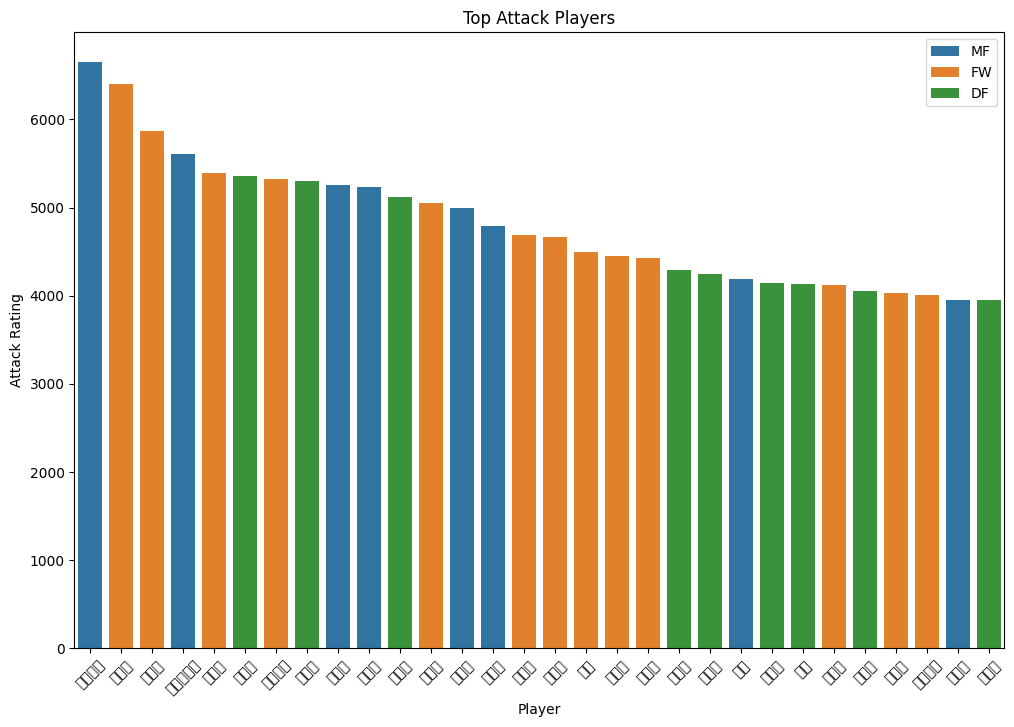

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

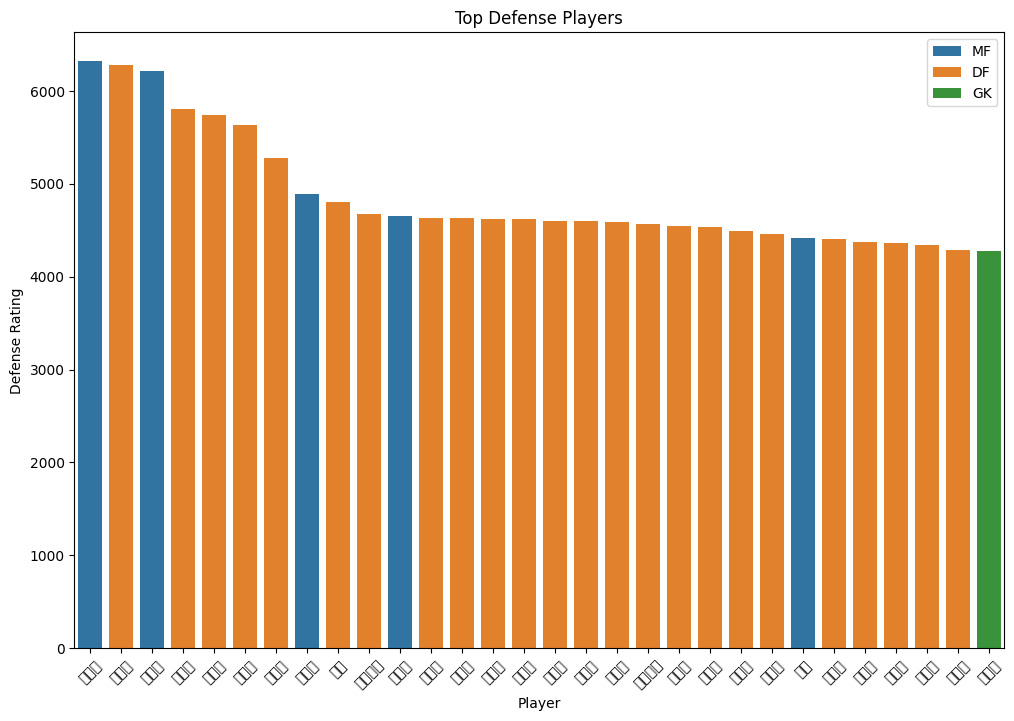

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

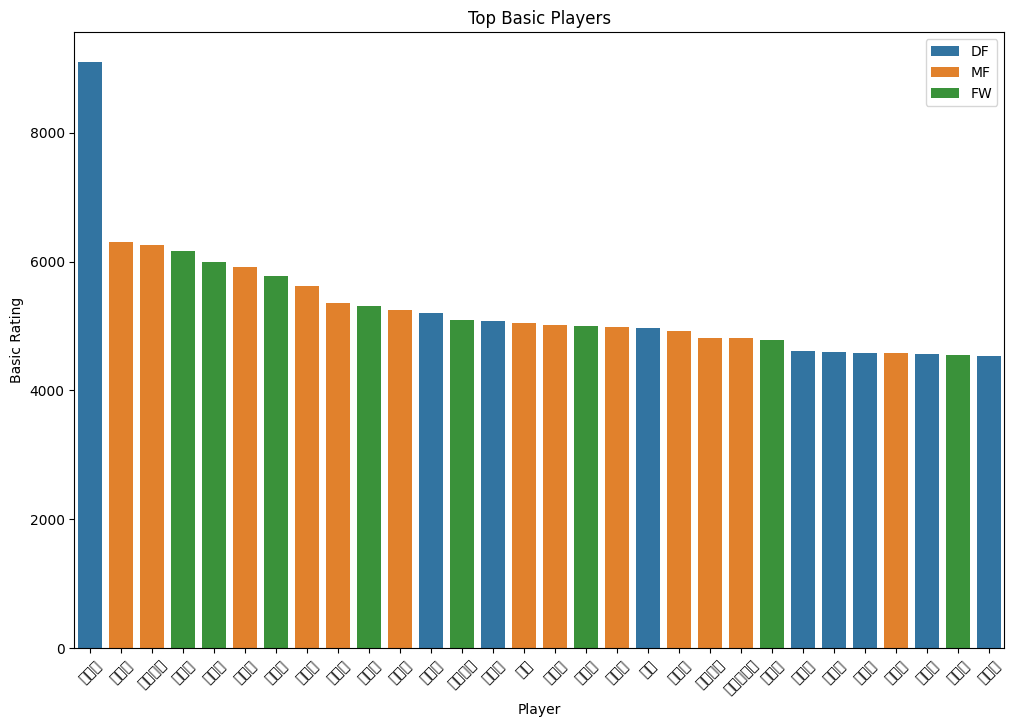

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54861 (\N{HANGUL SYLLABLE HONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

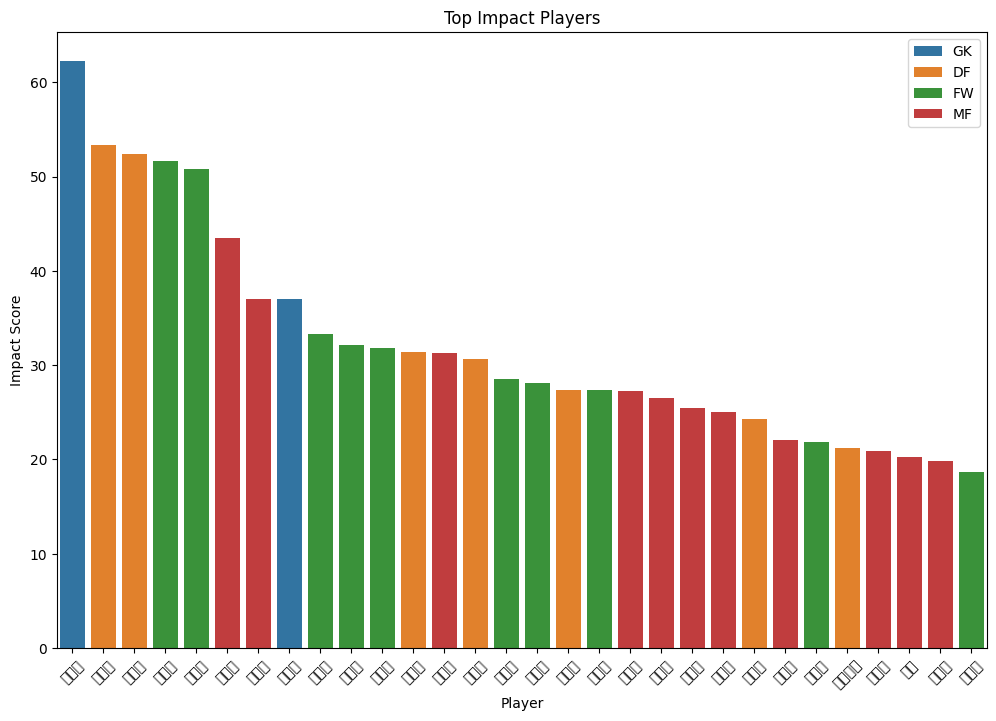

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot top players
def plot_top_players(df, category, title, y_label, N):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Player', y=category, hue='Position', data=df.head(N))
    plt.title(title)
    plt.xlabel('Player')
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.show()

# Plot top N players for each category
plot_top_players(top_attack_players, 'Attack_Rating', 'Top Attack Players', 'Attack Rating', N)
plot_top_players(top_defense_players, 'Defense_Rating', 'Top Defense Players', 'Defense Rating', N)
plot_top_players(top_basic_players, 'Basic_Rating', 'Top Basic Players', 'Basic Rating', N)
plot_top_players(top_Impact_players, 'Impact_score', 'Top Impact Players', 'Impact Score', N)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48731 (\N{HANGUL SYLLABLE BIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


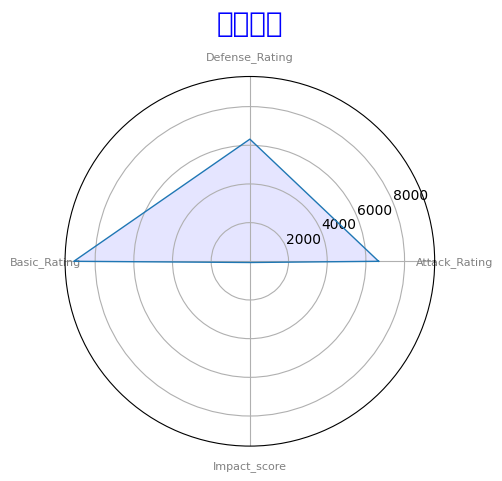

In [ ]:
from math import pi

def plot_radar_chart(player_stats, title):
    categories = list(player_stats.keys())
    values = list(player_stats.values())

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(title, size=20, color='blue', y=1.1)
    plt.show()

# 예시 레이더 차트
player_stats = {
    'Attack_Rating': top_attack_players.iloc[0]['Attack_Rating'],
    'Defense_Rating': top_defense_players.iloc[0]['Defense_Rating'],
    'Basic_Rating': top_basic_players.iloc[0]['Basic_Rating'],
    'Impact_score': top_Impact_players.iloc[0]['Impact_score']
}
plot_radar_chart(player_stats, top_attack_players.iloc[0]['Player'])


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/sea

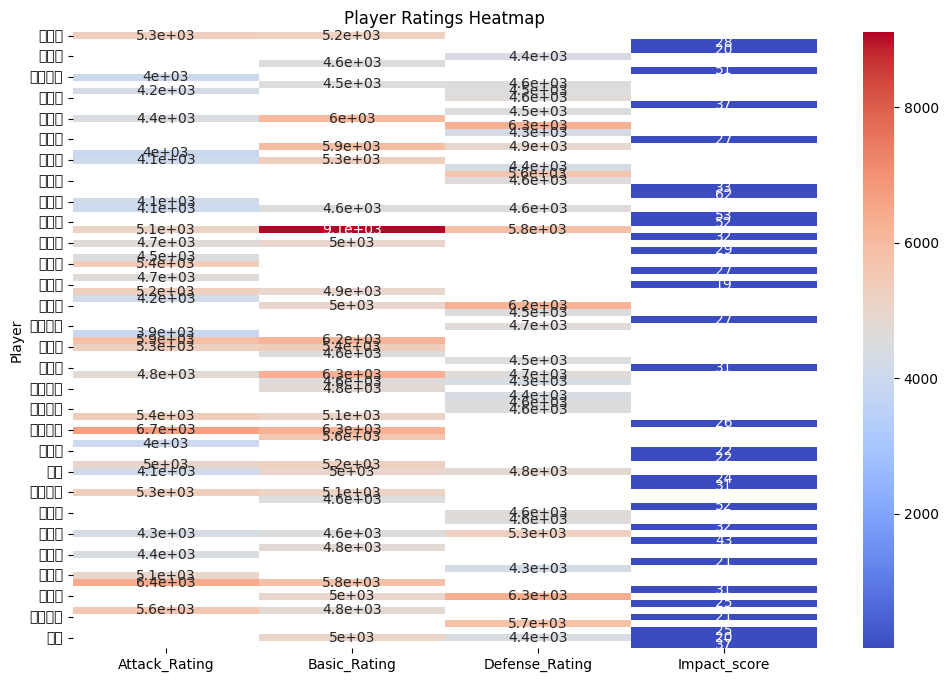

In [ ]:
# Combine all top players dataframes into a single dataframe
combined_df = pd.concat([top_attack_players, top_defense_players, top_basic_players, top_Impact_players], axis=0).drop_duplicates().reset_index(drop=True)

# Create a pivot table for heatmap
heatmap_data = combined_df.pivot_table(index='Player', values=['Attack_Rating', 'Defense_Rating', 'Basic_Rating', 'Impact_score'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Player Ratings Heatmap')
plt.show()


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.7 MB/s eta 0:00:00
